Assign 1.

Implement k-means clustering as a function

In [101]:
from __future__ import division  # always use float division
import numpy as np
from scipy.spatial.distance import cdist  # fast distance matrices
from scipy.cluster.hierarchy import dendrogram, linkage # you can use this
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for when you create your own dendrogram
from scipy.stats import multivariate_normal

In [102]:
def kmeans(X, k, max_iter=100):
    """ Performs k-means clustering

    Input:
    X: (d x n) data matrix with each datapoint in one column
    k: number of clusters
    max_iter: maximum number of iterations

    Output:
    mu: (d x k) matrix with each cluster center in one column
    r: assignment vector
    """
    centroids = X[np.random.choice(range(X.shape[0]), k, replace=False)]

    labels = None
    loss = 0

    for _ in range(max_iter):

        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        loss = np.sum(np.min(distances, axis=1))

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels, loss

## Assignment 3.
`kmloss` is a lenght k vector, which contains the loss function value after each agglomeration step.

`mergeidx` is a (k − 1) × 2 matrix, which contains the indices of the two clusters that were merged at each step. The index of the new (joint) cluster is the highest index plus one.


In [103]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

def kmeans(X, k, max_iter=100):
    """ Performs k-means clustering

    Input:
    X: (d x n) data matrix with each datapoint in one column
    k: number of clusters
    max_iter: maximum number of iterations

    Output:
    mu: (d x k) matrix with each cluster center in one column
    r: assignment vector
    """
    centroids = X[np.random.choice(range(X.shape[0]), k, replace=False)]

    distances = cdist(X, centroids)
    labels = np.argmin(distances, axis=1)
    loss = np.sum(np.min(distances, axis=1))

    for i in range(max_iter):

        old_labels = np.copy(labels)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        distances = cdist(X, new_centroids)
        labels = np.argmin(distances, axis=1)

        loss = np.sum(np.min(distances, axis=1))

        n_changed_clusters = np.array(labels == old_labels)

        # print(f"number of iterations: {i}, changed clusters: {len(n_changed_clusters[n_changed_clusters == False])} ")

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels, loss


def kmeans_agglo(X, r):
    """ Performs agglomerative clustering with k-means criterion

    Input:
    X: (d x n) data matrix with each datapoint in one column
    r: assignment vector

    Output:
    R: (k-1) x n matrix that contains cluster memberships before each step
    kmloss: vector with loss after each step
    mergeidx: (k-1) x 2 matrix that contains merge idx for each step
    """

    def kmeans_crit(X, r):
        """ Computes k-means criterion

        Input: 
        X: (d x n) data matrix with each datapoint in one column
        r: assignment vector

        Output:
        value: scalar for sum of euclidean distances to cluster centers
        """
        centroids = np.array([X[r == n].mean(axis=0) for n in np.unique(r)])
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

        return np.sum(np.min(distances, axis=1))

    k = len(np.unique(r))
    n = k
    R = np.zeros((k - 1, X.shape[0]))
    mergeidx = np.zeros((k - 1, 2))
    kmloss = np.zeros(k)
    kmloss[0] = kmeans_crit(X, r)
    for i in reversed(range(k - 1)):
        min_l = None
        min_r = r
        min_x = 0
        min_y = 0
        for x in np.unique(r):
            for y in np.unique(r):
                if x != y:
                    new_r = np.copy(r)
                    new_r[new_r == x] = n
                    new_r[new_r == y] = n
                    new_loss = kmeans_crit(X, new_r)
                    if min_l is None or min_l > new_loss:
                        min_l = new_loss
                        min_r = np.copy(new_r)
                        min_x = x
                        min_y = y
        kmloss[k-i-1] = min_l
        mergeidx[k-i-2] = [min_x, min_y]
        R[k-i-2] = min_r
        r = min_r
        n += 1

    return R, kmloss, mergeidx

def agglo_dendro(kmloss, mergeidx):
    """ Plots dendrogram for agglomerative clustering

    Input:
    kmloss: vector with loss after each step
    mergeidx: (k-1) x 2 matrix that contains merge idx for each step
    """
    idx = np.array(mergeidx)
    loss = np.array(kmloss[1:])  # Extract loss values
    after_idx = np.max(mergeidx, axis=1) + 1

    # Combine indices, loss values, and newly formed cluster indices
    matrix_with_column = np.column_stack((idx, loss.T, after_idx))

    # Plot the dendrogram
    plt.figure()
    dendrogram(matrix_with_column)
    plt.ylim(kmloss[0],)
    plt.title('Dendrogram')
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.show()




## Assignment 4.
Write a function that computes the probability density function for a multivariate Gaussian distribution

$y = norm_pdf(X, mu, C)$

Input:
1. `X` is a n × d matrix of datapoints, 
2. `mu` is a vector with d length, which is the center of the Gaussians distribution 
3. `C` is the covariance matrix of the Gaussian distribution as a d × d matrix. 

Output:
the probability density function evaluated at all points in X as a length n vector:

In [209]:
import numpy as np

def norm_pdf(X, mu, C):
    d = X.shape[1]
    
    # Compute the determinant and the pseudo-inverse of the covariance matrix
    det_C = np.linalg.det(C)
    inv_C = np.linalg.pinv(C)
    
    # Compute coefficient
    coeff = 1 / (np.sqrt((2 * np.pi) ** d * det_C))
    
    # Compute X_i - mu
    diff = X - mu
    
    # Compute the exponent term for each data point
    exponent = -0.5 * np.sum(diff @ inv_C * diff, axis=1)
    
    # Compute the PDF values
    pdf_values = coeff * np.exp(exponent)
    
    return pdf_values


X = np.array([[1, 2], [2, 3], [3, 4]])
mu = np.array([2, 3])
C = np.array([[1, 0], [0, 1]])

# Calculate the PDF at all points in X
pdf_values = norm_pdf(X, mu, C)
pdf_values

array([0.05854983, 0.15915494, 0.05854983])

In [199]:
from scipy.stats import multivariate_normal


def gmm(X, k, max_iter=100, init_kmeans=False, eps=1e-3, kmeans_func=None):
    """ Implements EM for Gaussian Mixture Models """
    n, d = X.shape  # Number of samples (n) and dimensions (d)
    
    # Initialize means using kmeans or randomly
    if init_kmeans:
        if kmeans_func is None:
            raise ValueError("kmeans function must be provided for initialization with kmeans")
        _, indices, _ = kmeans_func(X, k, 100)
    else:
        indices = np.random.choice(n, k, replace=False)
    mu = X[indices, :]  # Initial means

    # Initialize covariances to identity matrices
    sigma = [np.eye(d) for _ in range(k)]

    # Initialize weights to be equal
    pi = np.full(k, 1 / k)
    log_likelihood = 0

    def expectation(X, pi, mu, sigma):
        """ Calculate responsibilities (gamma) """
        gamma = np.zeros((n, k))
        for j in range(k):
            pdf = multivariate_normal(mean=mu[j], cov=sigma[j], allow_singular=True).pdf(X)
            gamma[:, j] = pi[j] * pdf
        gamma /= gamma.sum(axis=1, keepdims=True)
        return gamma

    def maximization(X, gamma):
        """ Update pi, mu, and sigma """
        Nk = gamma.sum(axis=0)  # Sum responsibilities for each cluster
        pi = Nk / n
        mu = np.dot(gamma.T, X) / Nk[:, np.newaxis]
        sigma = [np.dot((gamma[:, j][:, np.newaxis] * (X - mu[j])).T, X - mu[j]) / Nk[j] for j in range(k)]
        return pi, mu, sigma

    for l in range(max_iter):
        gamma = expectation(X, pi, mu, sigma)
        prev_log_likelihood = log_likelihood
        log_likelihood = np.sum(np.log(np.dot(gamma, pi)))
        pi, mu, sigma = maximization(X, gamma)
        if np.abs(log_likelihood - prev_log_likelihood) < eps:
            break
        print(f"number of iterations: {l+1}, log likelihood: {log_likelihood}")
    
    return pi, mu, sigma, log_likelihood, gamma


## Assignment 9.


In [106]:
import scipy.io
data = scipy.io.loadmat("C:/Users/Tue/tub/Lab-ML/problem_set1/data/usps.mat")
data.keys()

usps_X = np.array(data.get('data_patterns'))
usps_Y = np.array(data.get('data_labels'))

usps_Y.shape, usps_X.shape

((10, 2007), (256, 2007))

In [167]:
usps_Y
indices = np.argmax(usps_Y.T == 1, axis=1)
labels_1d = indices + 1

labels_1d

array([10,  7,  4, ...,  5,  1,  2], dtype=int64)

In [210]:
import numpy as np
import pandas as pd


df = pd.DataFrame(usps_X.T)

indices = np.argmax(usps_Y.T == 1, axis=1)
labels_1d = indices + 1
df['Y'] = labels_1d

# get the centers of original clustering
centers = df.groupby('Y').mean()
centers.shape





(10, 256)

In [107]:
# Parameters
k = 10
max_iter = 100

# Apply k-means clustering
mu_kmeans, r_kmeans, loss_kmeans = kmeans(usps_X.T, k, max_iter)

# Print the results
print("K-Means Clustering Results:")
print("Cluster Centroids (mu):", mu_kmeans)
print("Cluster Memberships (r):", r_kmeans)
print("Loss:", loss_kmeans)


K-Means Clustering Results:
Cluster Centroids (mu): [[-0.99512187 -0.98492739 -0.95539008 ... -0.90717475 -0.96667718
  -0.99055118]
 [-0.96803244 -0.89576837 -0.78330243 ... -0.74592834 -0.8311282
  -0.92672168]
 [-0.99476382 -0.98056318 -0.9395464  ... -0.99758187 -0.99986993
  -0.99999727]
 ...
 [-0.99274999 -0.97418232 -0.92827258 ... -0.87782897 -0.95517719
  -0.98842425]
 [-0.97888122 -0.92659639 -0.82302543 ... -0.99567626 -0.99928904
  -0.99996164]
 [-0.99939137 -0.99803112 -0.99785017 ... -0.99597273 -0.99900195
  -0.9999213 ]]
Cluster Memberships (r): [8 0 6 ... 2 3 9]
Loss: 11977.612738577855


In [175]:
abs_diff_kmeans = np.sum(np.sum(np.abs((mu_kmeans-centers))))
abs_diff_kmeans

761.7647599525678

In [202]:
# Assuming em_gmm function is defined as:
# def em_gmm(X, k, max_iter=100, init_kmeans=False, tol=1e-5):
#     ...

# Apply EM-GMM clustering
pi_gmm, mu_gmm, sigma_gmm, loglik_gmm, gamma = gmm(usps_X.T, 10, init_kmeans=False, kmeans_func=kmeans)

# Print the results
print("EM-GMM Clustering Results:")
print("Mixture Proportions (pi):", pi_gmm)
print("Cluster Centroids (mu):", mu_gmm)
print("Covariance Matrices (sigma):", sigma_gmm)
print("Log-Likelihood:", -loglik_gmm)


number of iterations: 1, log likelihood: -4621.28828163905


c:\Users\Tue\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_multivariate.py:860: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logpdf(x))
C:\Users\Tue\AppData\Local\Temp\ipykernel_31848\195630005.py:30: RuntimeWarning: invalid value encountered in divide
  gamma /= gamma.sum(axis=1, keepdims=True)


number of iterations: 2, log likelihood: nan


ValueError: array must not contain infs or NaNs

In [177]:
mu_gmm.shape

(2, 256)

In [201]:
abs_diff_gmm = np.sum(np.sum(np.abs((mu_gmm-centers))))
abs_diff_gmm

ValueError: Unable to coerce to DataFrame, shape must be (10, 256): given (2, 256)

In [148]:
_, r, _ = kmeans(usps_X, 10, 100)
_, usps_kmloss, usps_mergeidx = kmeans_agglo(usps_X, r)


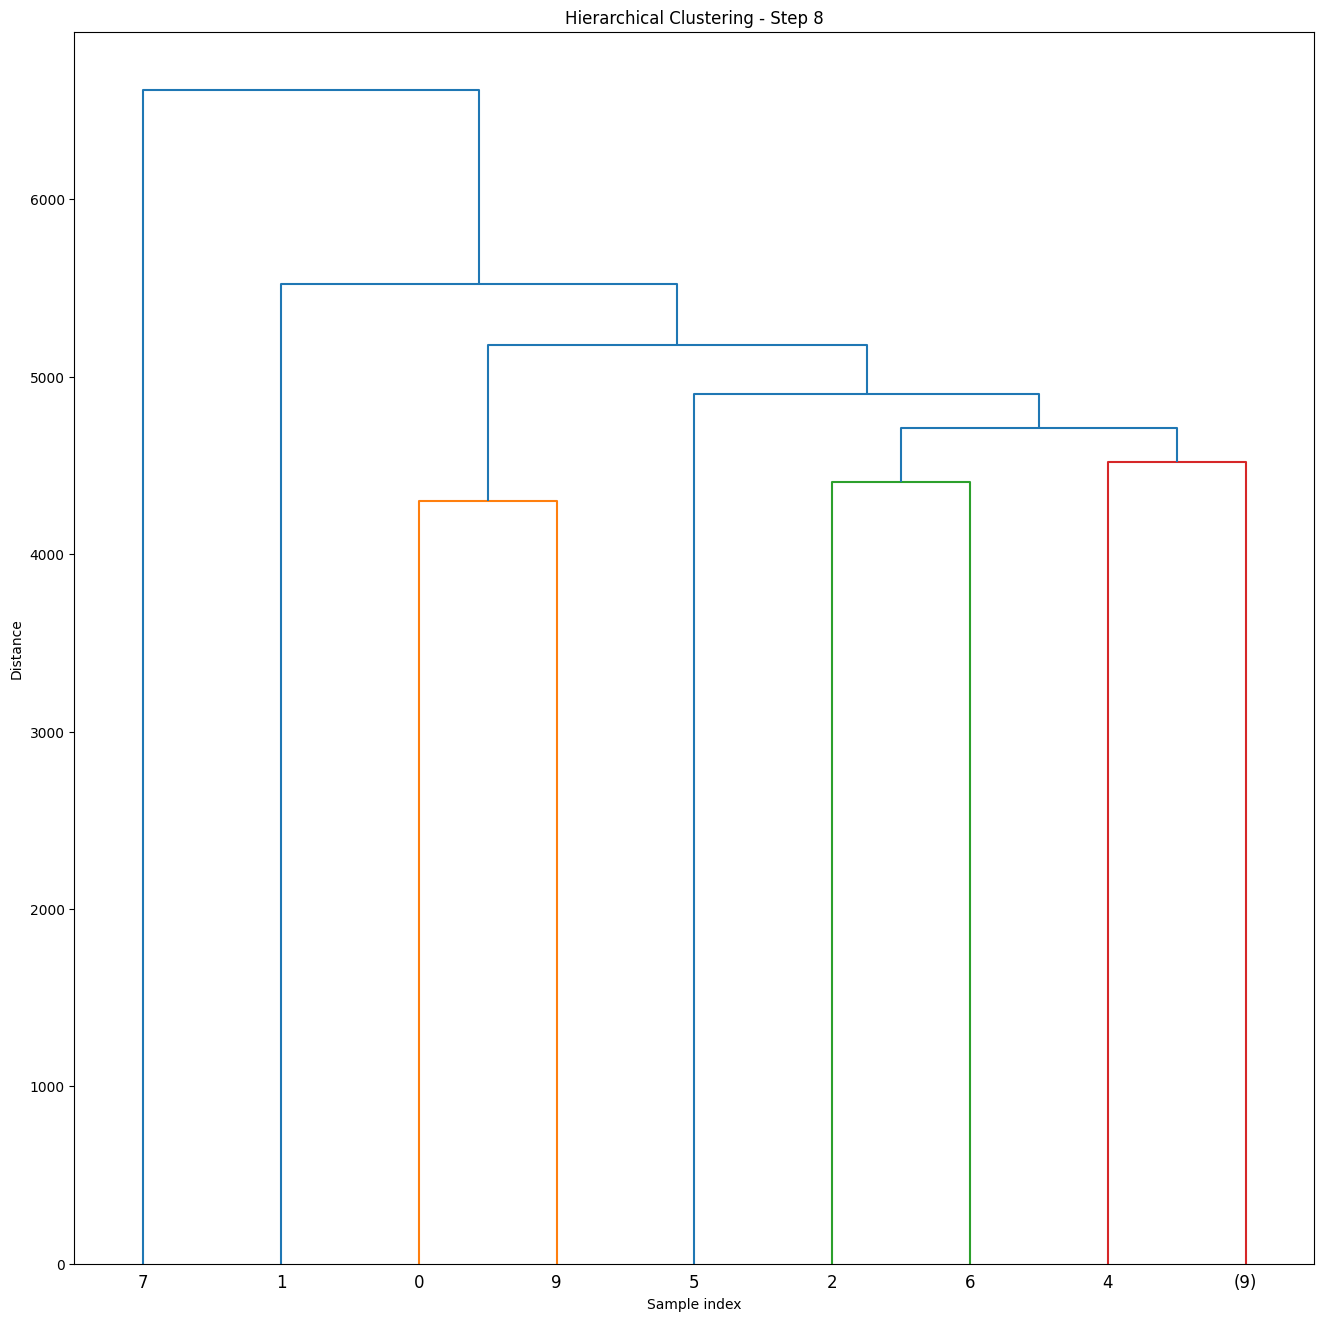

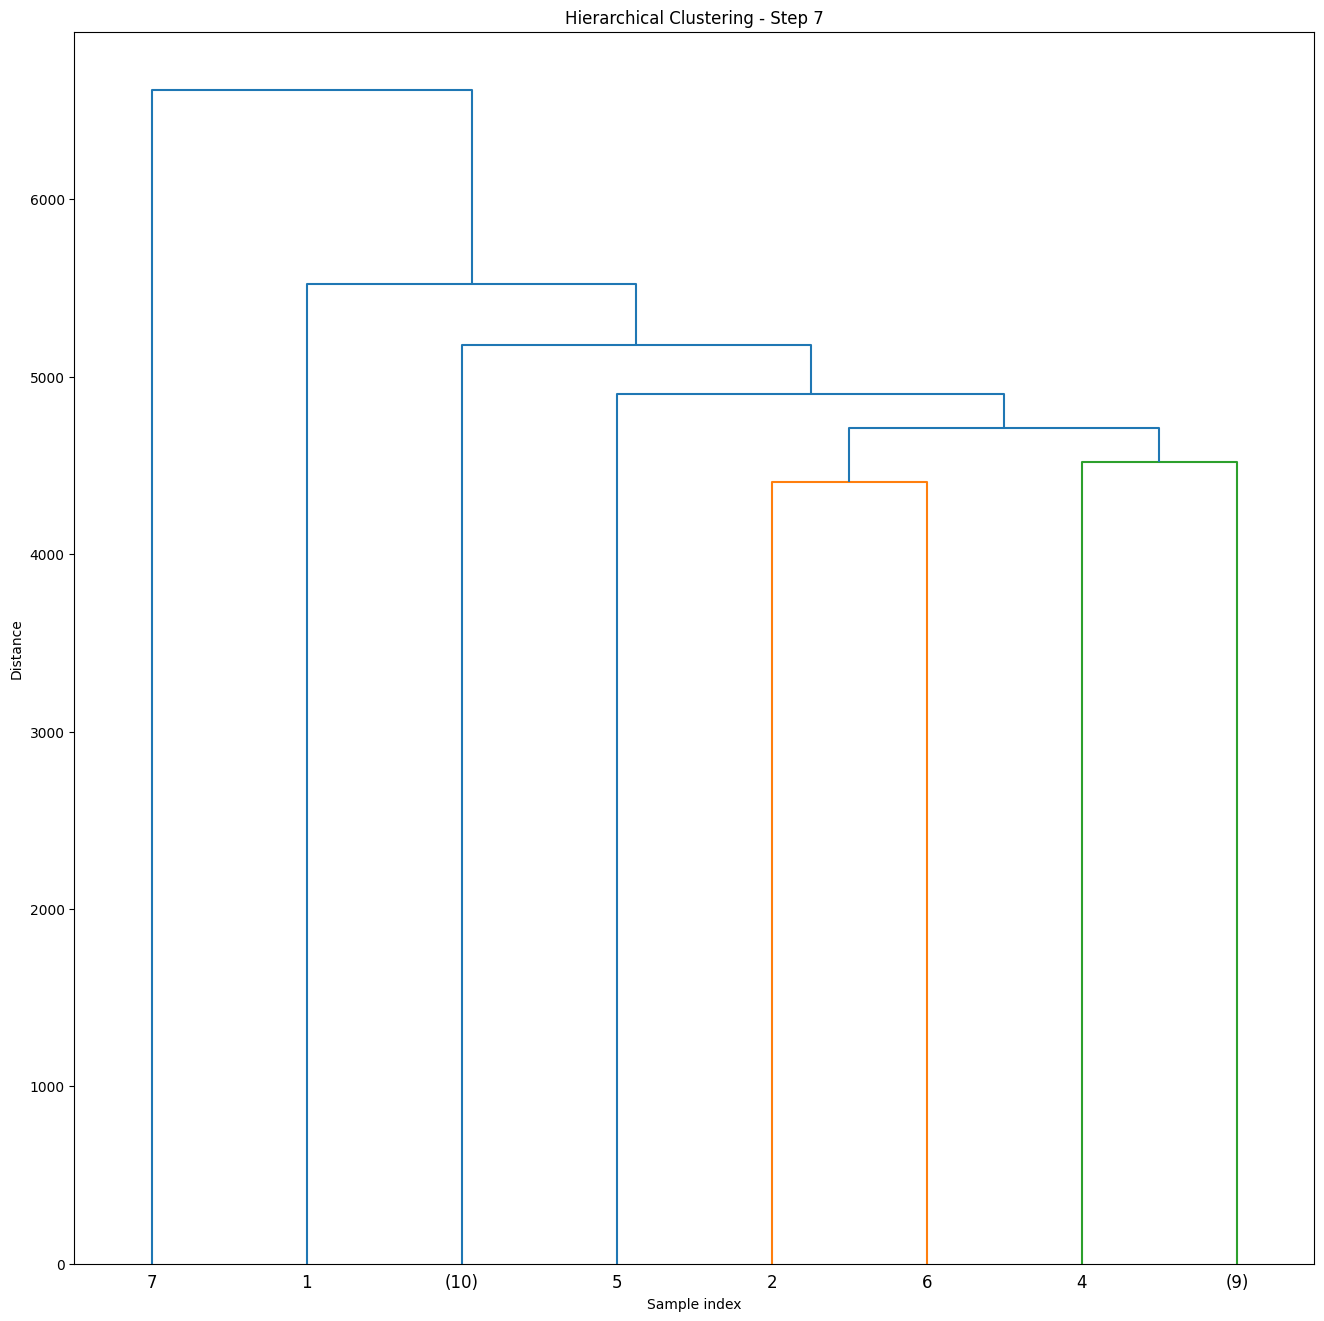

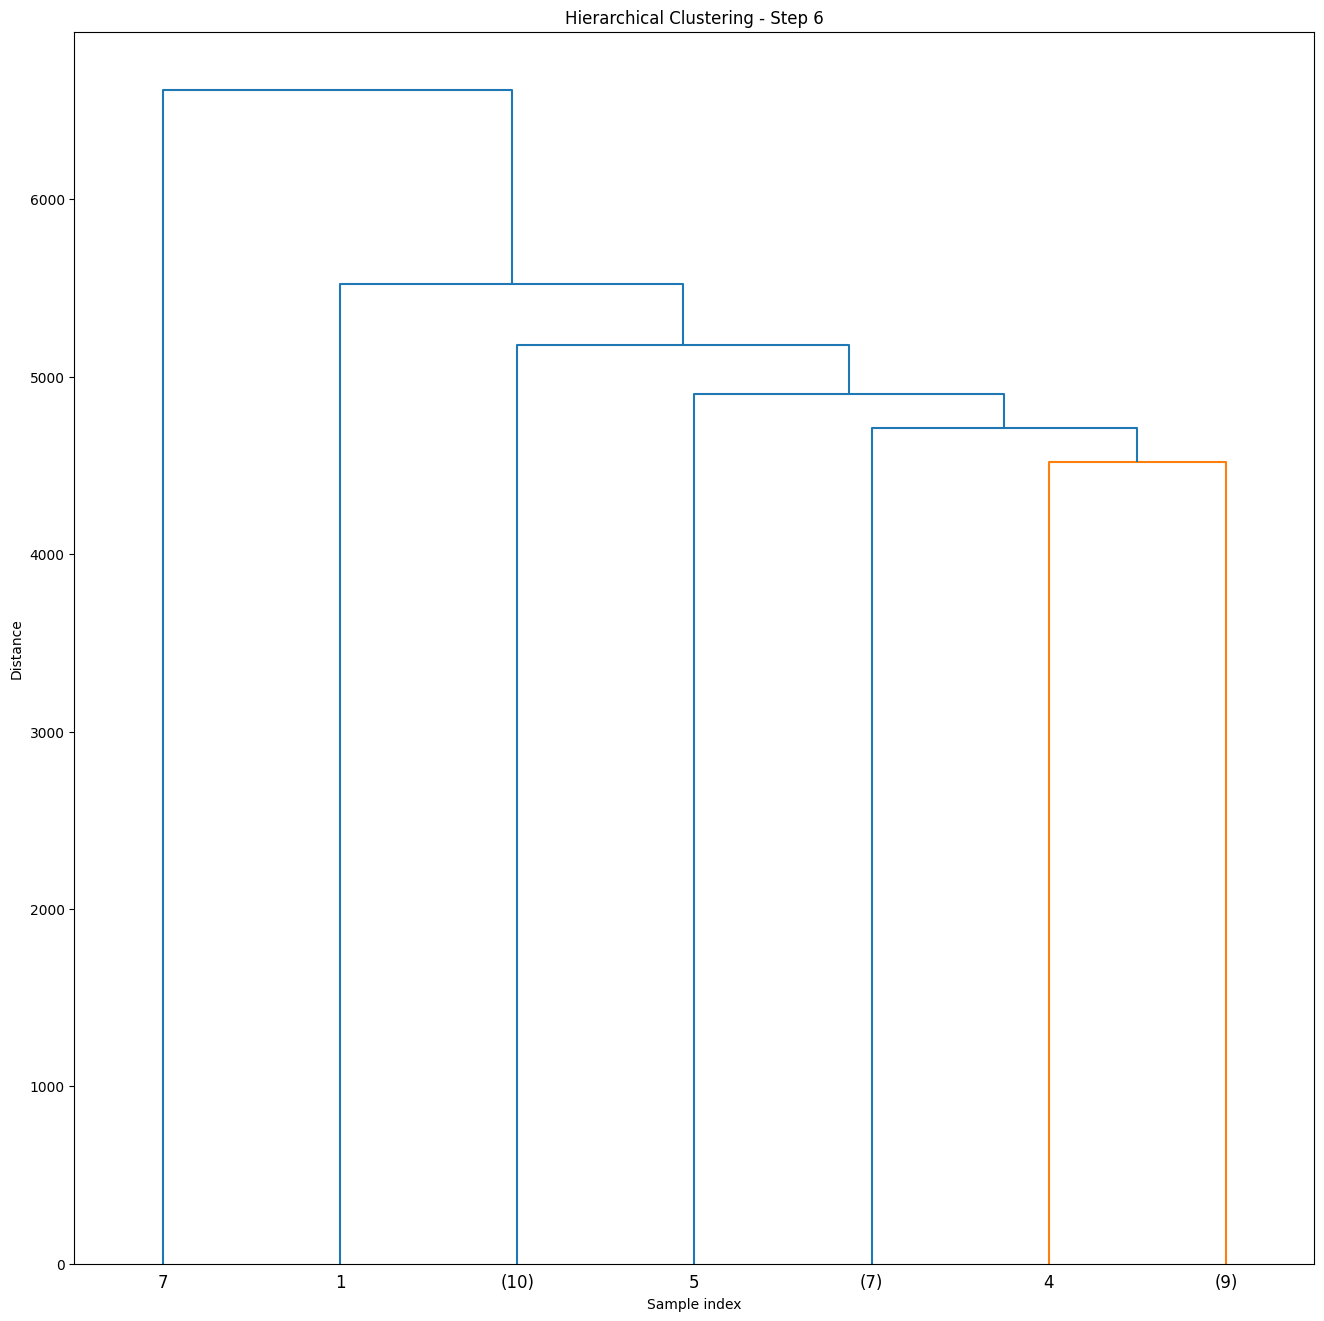

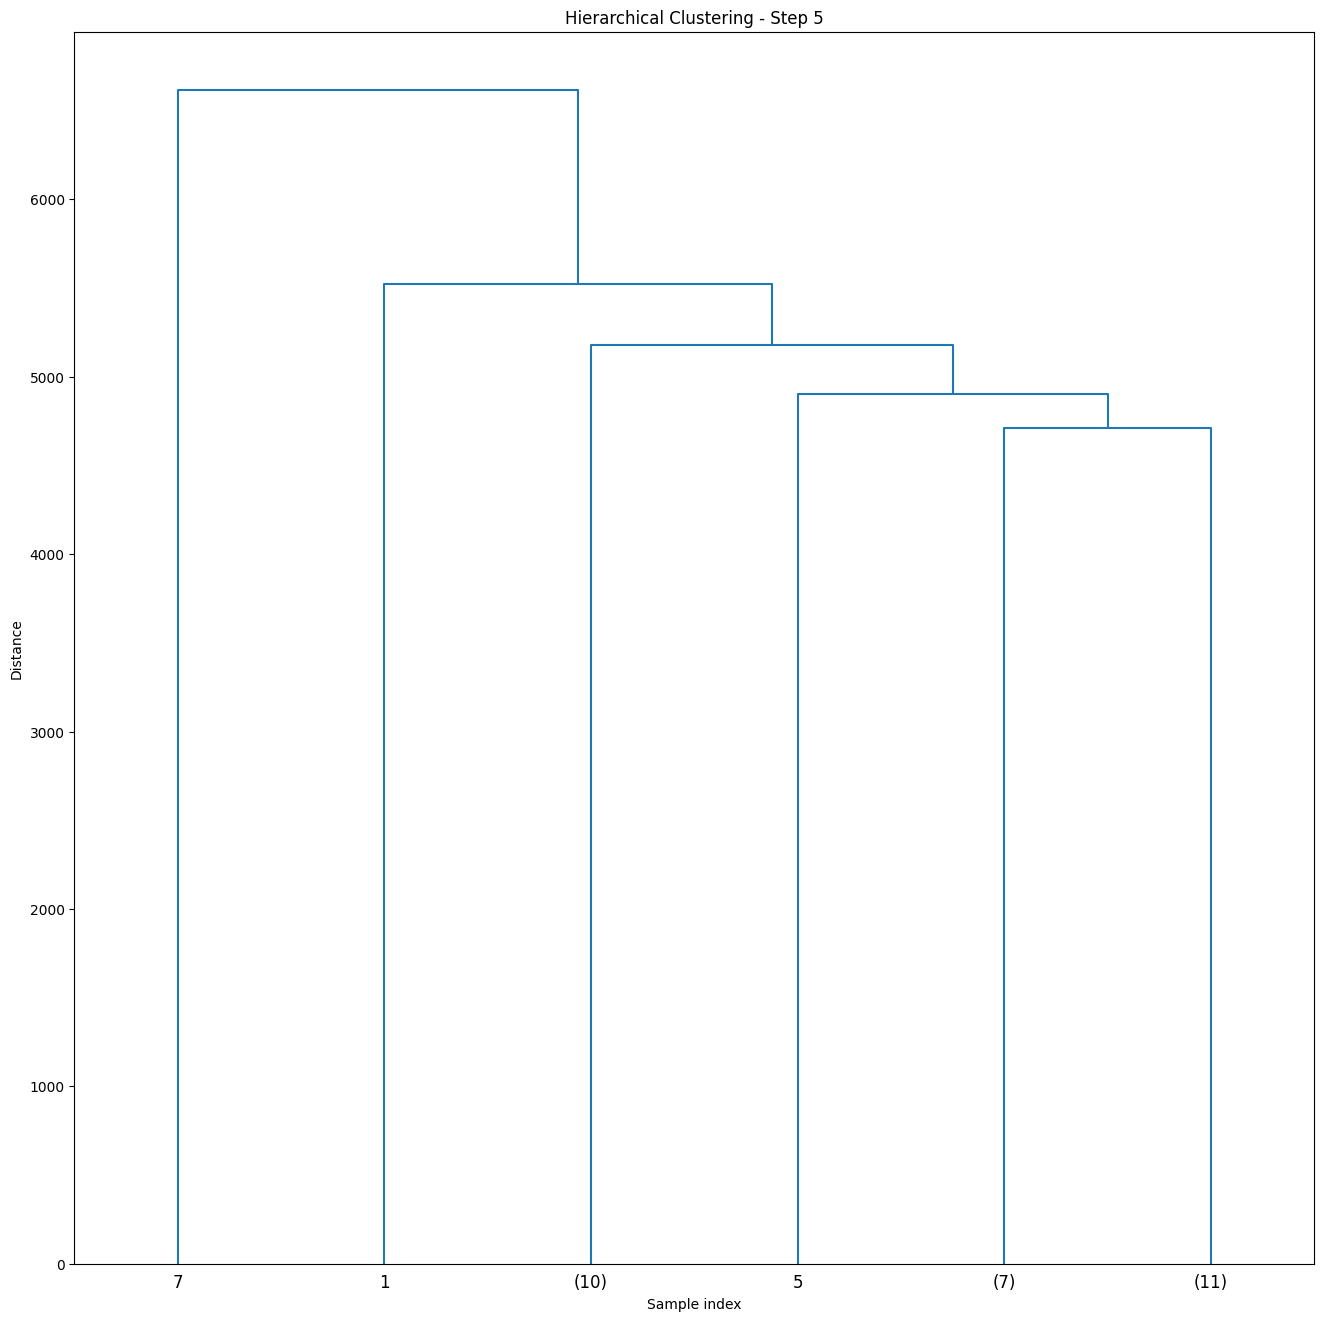

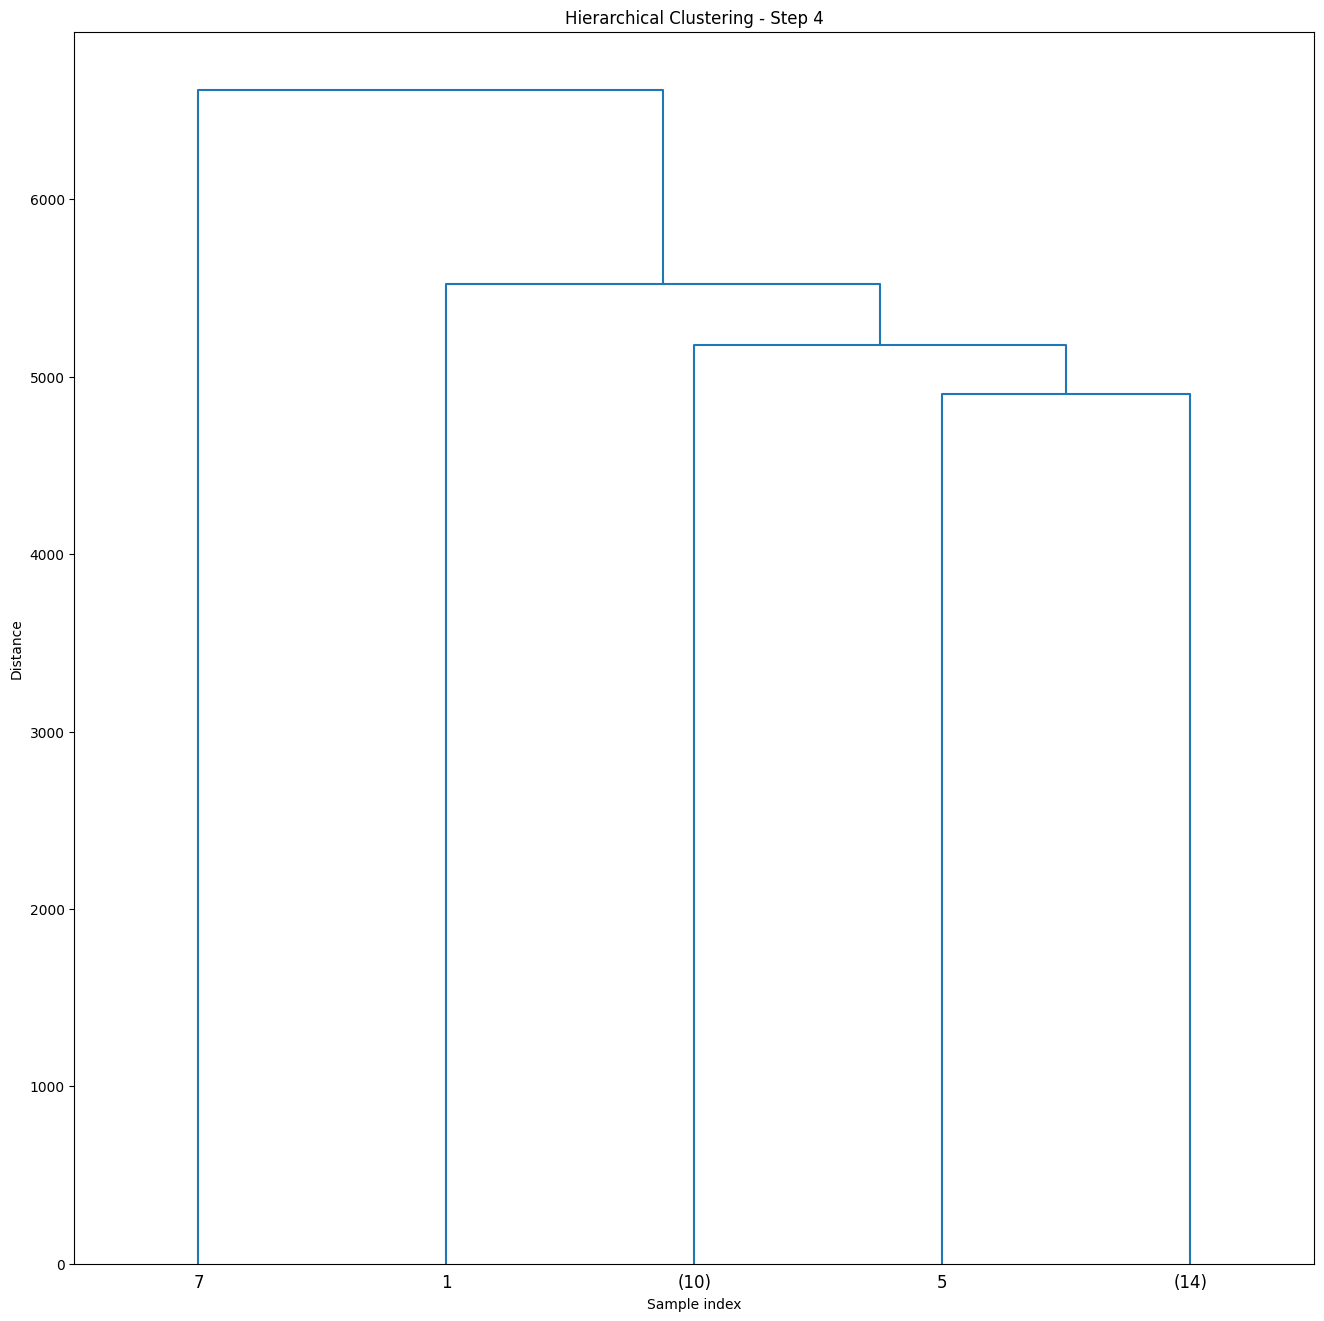

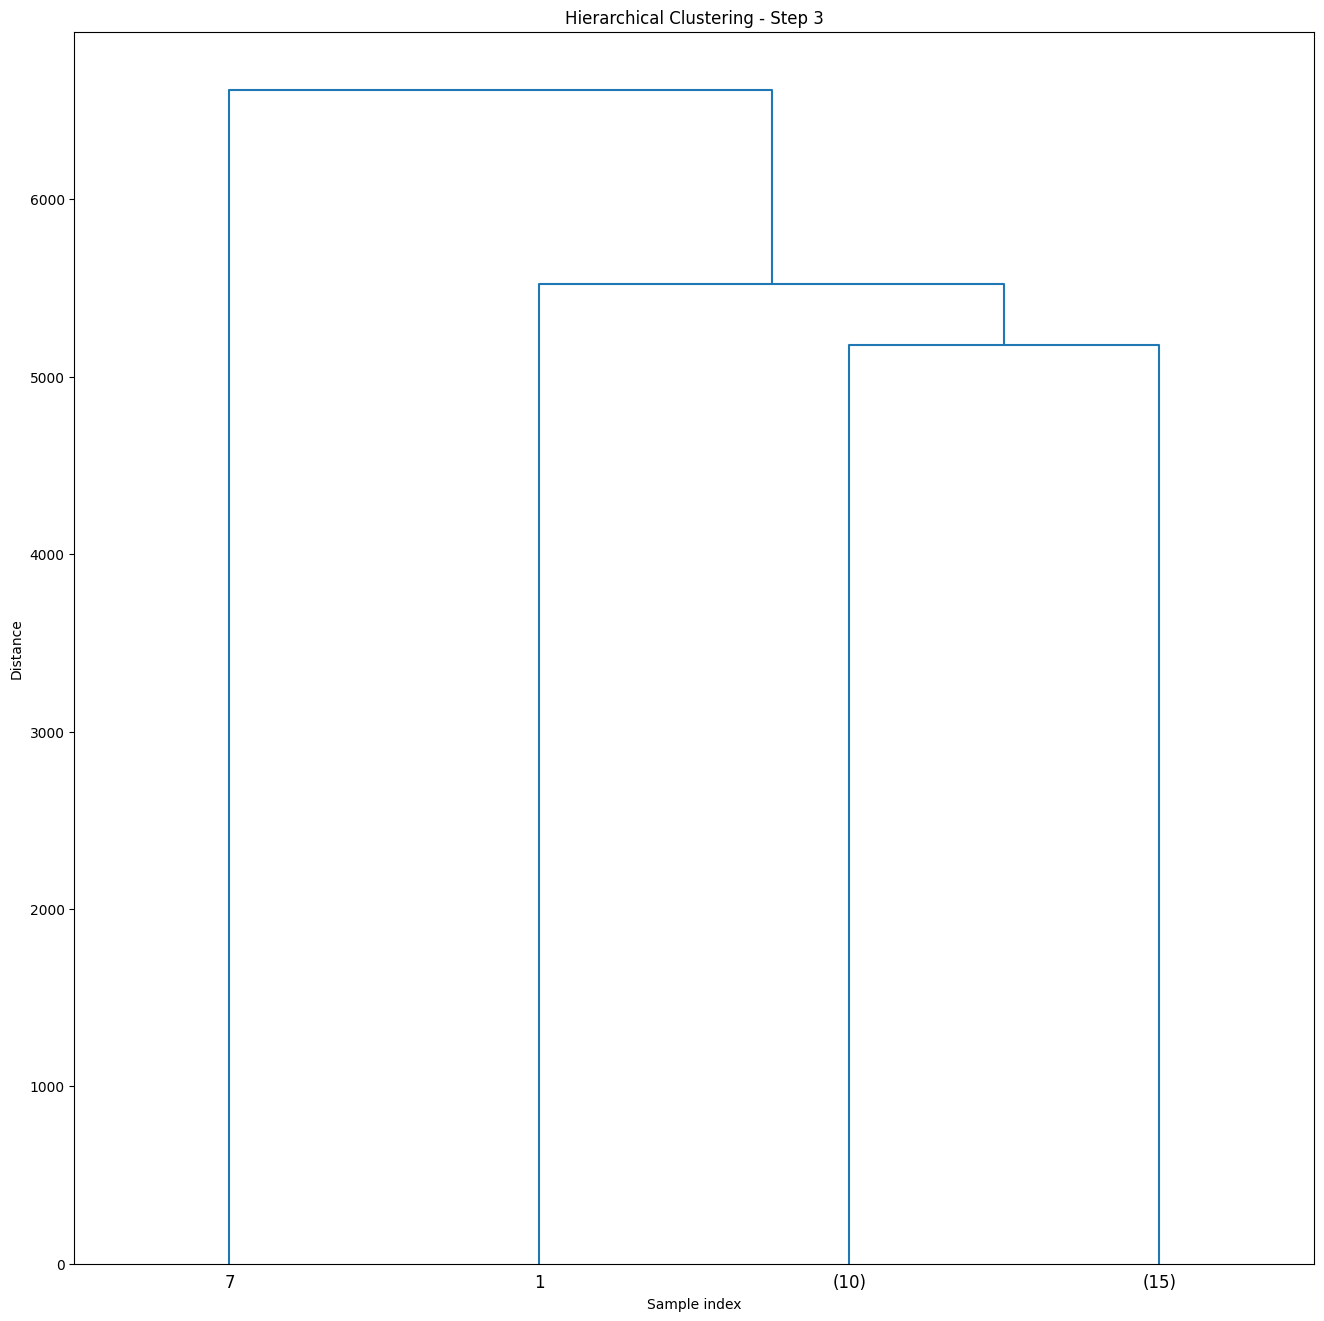

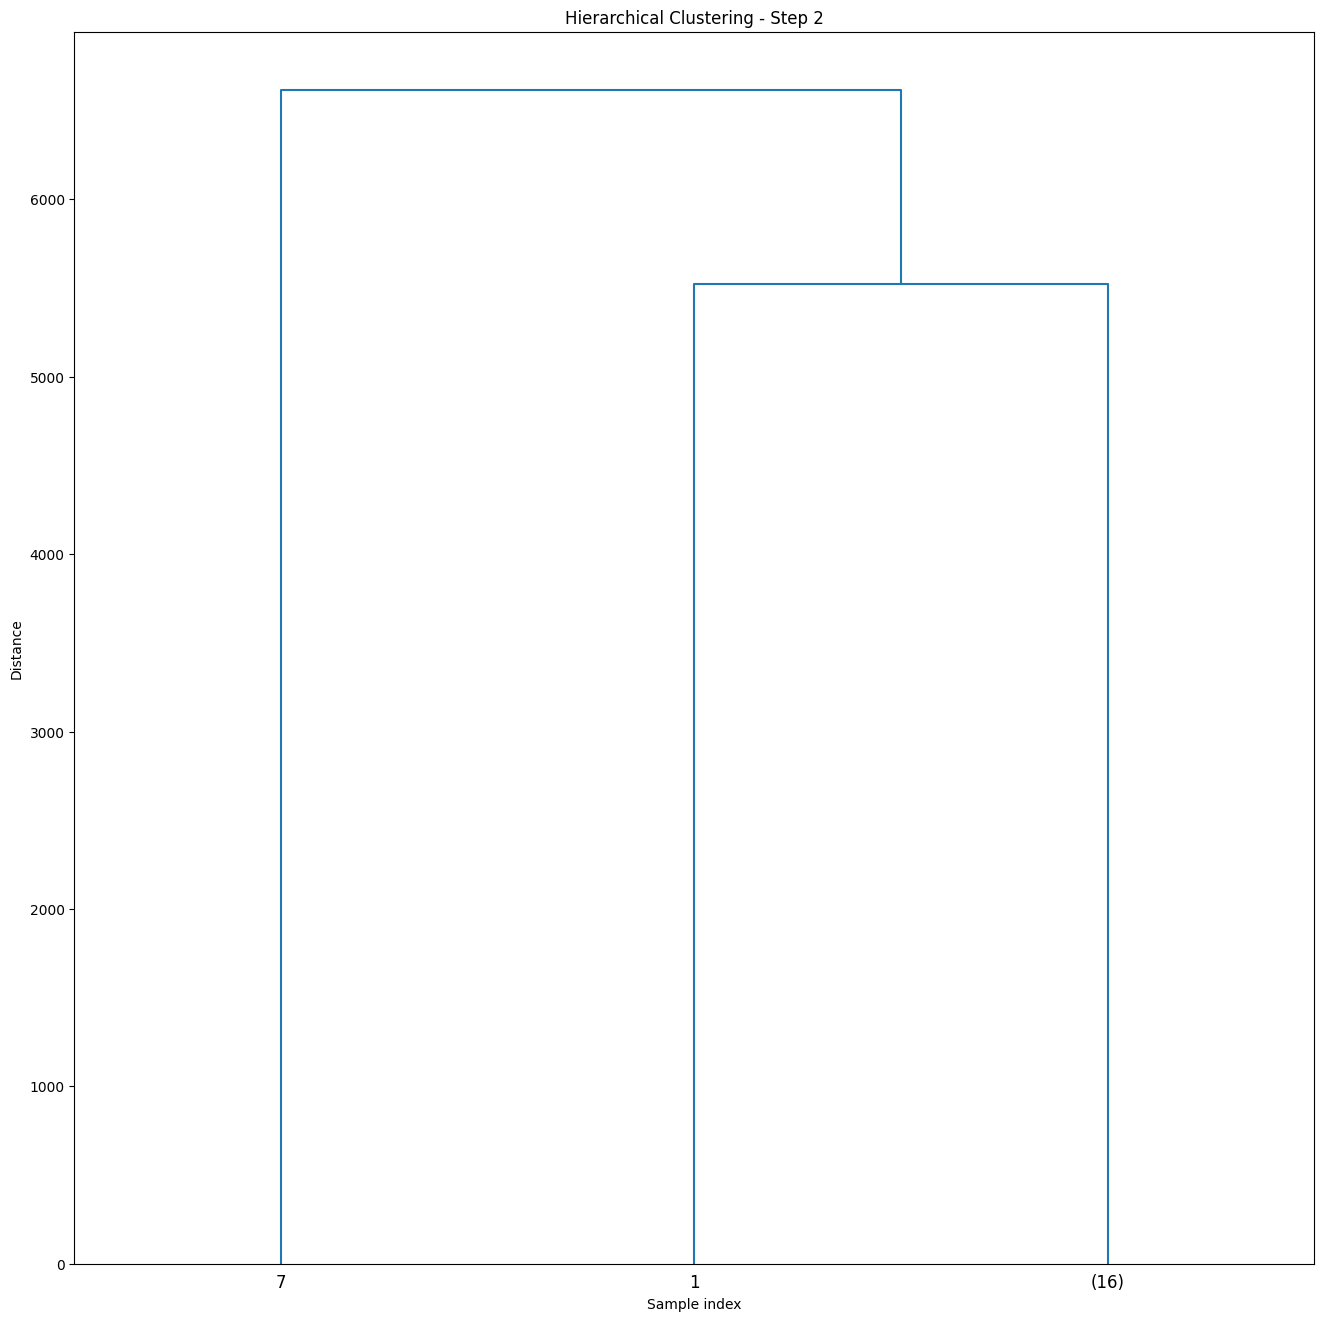

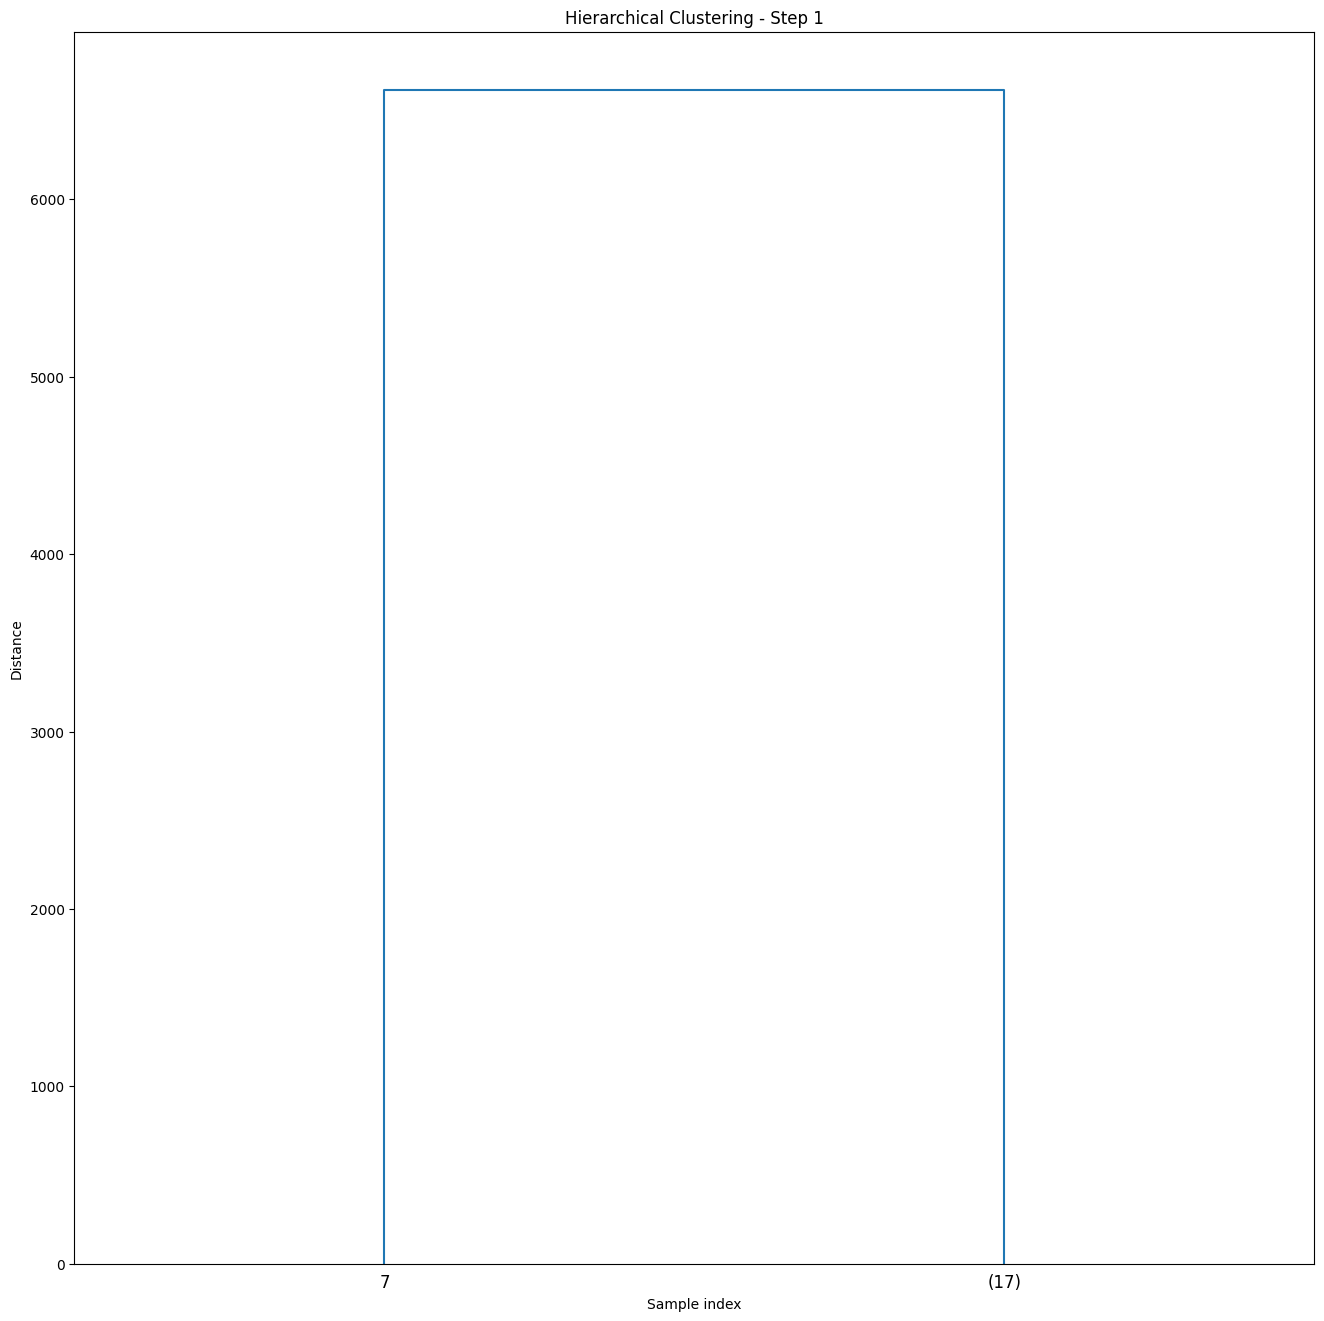

In [150]:
idx = np.array(usps_mergeidx)
loss = np.array(usps_kmloss[1:])  # Extract loss values
after_idx = np.max(usps_mergeidx, axis=1) + 1

# Combine indices, loss values, and newly formed cluster indices
matrix_with_column = np.column_stack((idx, loss.T, after_idx))
# 绘制聚类的每一步过程
def plot_dendrogram_each_step(Z):
    num_samples = Z.shape[0]
    for i in range(num_samples - 1):
        plt.figure(figsize=(16, 16))
        dendrogram(Z, truncate_mode='lastp', p=num_samples - i, show_contracted=False)
        plt.title(f"Hierarchical Clustering - Step {num_samples - i -1}")
        plt.xlabel("Sample index")
        plt.ylabel("Distance")
        plt.show()

# 调用函数绘制每一步的树状图
plot_dendrogram_each_step(matrix_with_column)


# Assignment 10.
1. Load dataset lab_data.npz. It contains the observations in X and whether this data point is an outlier in Y (−1 for outlier, +1 for inlier).